# SAM 2.1 Video Segmentation with GPU
Segment surgical videos using Segment Anything Model 2.1 (Hiera) with CUDA acceleration

In [1]:
from pathlib import Path
import glob
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️  Warning: CUDA not available, will run on CPU (slower)")

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
GPU Memory: 6.00 GB


In [2]:
# Set up paths
BASE_DIR = Path("..").resolve()
VIDEO_DIR = BASE_DIR / "data" / "SurgiSR4K" / "data" / "videos" / "3840x2160_30fps"
CHECKPOINT = BASE_DIR / "checkpoints" / "sam2.1_hiera_large.pt"
OUTPUT_DIR = BASE_DIR / "data" / "processed" / "sam2_video_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Get list of videos
videos = sorted(glob.glob(str(VIDEO_DIR / "*.avi")))
print(f"Found {len(videos)} videos")
print(f"Checkpoint: {CHECKPOINT.name}")
print(f"Output directory: {OUTPUT_DIR}")

Found 55 videos
Checkpoint: sam2.1_hiera_large.pt
Output directory: C:\Users\msi\Documents\DataScienceFinal\data\processed\sam2_video_outputs


In [3]:
# Install SAM2 if not already installed
!pip install git+https://github.com/facebookresearch/segment-anything-2.git

  Cloning https://github.com/facebookresearch/segment-anything-2.git to c:\users\msi\appdata\local\temp\pip-req-build-ob_3a8sz
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with stat

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git 'C:\Users\msi\AppData\Local\Temp\pip-req-build-ob_3a8sz'


In [9]:
# Load SAM2.1 model - simplified approach
from sam2.build_sam import build_sam2_video_predictor
from hydra import initialize_config_dir, compose
from hydra.core.global_hydra import GlobalHydra
import sam2
from pathlib import Path

print("Loading SAM 2.1 Hiera Large model...")

# Get SAM2 config directory for sam2.1
sam2_dir = Path(sam2.__file__).parent
config_dir = str(sam2_dir / "configs")

# Clear any existing Hydra instance
GlobalHydra.instance().clear()

# Initialize Hydra with SAM2 config directory
initialize_config_dir(config_dir=config_dir, version_base=None)

# Build video predictor with sam2.1 config
predictor = build_sam2_video_predictor(
    config_file="sam2.1/sam2.1_hiera_l.yaml",
    ckpt_path=str(CHECKPOINT),
    device=device
)

print("✓ SAM 2.1 model loaded successfully!")
print(f"  Model device: {device}")

Loading SAM 2.1 Hiera Large model...
✓ SAM 2.1 model loaded successfully!
  Model device: cuda
✓ SAM 2.1 model loaded successfully!
  Model device: cuda


In [14]:
def segment_video(video_path, output_path, predictor, resize_width=960):
    """
    Segment a video using SAM2 and save with overlay
    """
    import tempfile
    import shutil
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"❌ Could not open {video_path}")
        return False
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"  Original: {orig_width}x{orig_height} @ {fps:.1f} fps, {total_frames} frames")
    print(f"  Processing at: {resize_width}x{int(orig_height * resize_width / orig_width)}")
    
    # Create temp directory for frames
    temp_dir = tempfile.mkdtemp()
    frames_dir = Path(temp_dir) / "frames"
    frames_dir.mkdir(exist_ok=True)
    
    # Extract and resize frames
    print("  Extracting frames...")
    frame_idx = 0
    frame_files = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame
        scale = resize_width / orig_width
        resize_height = int(orig_height * scale)
        frame_resized = cv2.resize(frame, (resize_width, resize_height))
        
        # Save frame
        frame_file = frames_dir / f"{frame_idx:06d}.jpg"
        cv2.imwrite(str(frame_file), frame_resized)
        frame_files.append((frame_file, frame))
        frame_idx += 1
    
    cap.release()
    
    # Initialize SAM2 video predictor with frames directory
    print("  Initializing predictor...")
    inference_state = predictor.init_state(video_path=str(frames_dir))
    
    # Add a point prompt at center of first frame
    h, w = resize_height, resize_width
    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=0,
        obj_id=1,
        points=np.array([[w//2, h//2]], dtype=np.float32),
        labels=np.array([1], dtype=np.int32),
    )
    
    # Propagate through video
    print("  Propagating segmentation...")
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    
    # Create output video with overlays
    print("  Creating output video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (orig_width, orig_height))
    
    for idx, (frame_file, original_frame) in enumerate(tqdm(frame_files, desc="  Writing frames")):
        if idx in video_segments and 1 in video_segments[idx]:
            # Get mask and resize to original size
            mask = video_segments[idx][1].squeeze()
            mask_resized = cv2.resize(mask.astype(np.uint8), (orig_width, orig_height))
            
            # Create overlay (green color)
            overlay = original_frame.copy()
            overlay[mask_resized > 0] = [0, 255, 0]  # Green in BGR
            
            # Blend
            result = cv2.addWeighted(original_frame, 0.7, overlay, 0.3, 0)
        else:
            result = original_frame
        
        out.write(result)
    
    out.release()
    
    # Cleanup temp directory
    shutil.rmtree(temp_dir)
    
    print(f"  ✓ Saved to {output_path.name}")
    return True

In [15]:
# Process videos (start with first 3 for testing)
N_VIDEOS = 3

print(f"\n🎬 Processing {N_VIDEOS} videos with SAM 2.1...\n")

for i, video_path in enumerate(videos[:N_VIDEOS]):
    video_name = Path(video_path).name
    output_path = OUTPUT_DIR / f"sam2_segmented_{video_name}"
    
    print(f"[{i+1}/{N_VIDEOS}] {video_name}")
    
    success = segment_video(video_path, output_path, predictor, resize_width=960)
    
    if success:
        print(f"  ✓ Completed\n")
    else:
        print(f"  ❌ Failed\n")

print("🎉 All videos processed!")
print(f"📂 Output location: {OUTPUT_DIR}")


🎬 Processing 3 videos with SAM 2.1...

[1/3] vid_01_3840x2160_5_sec_1_tool.avi
  Original: 3840x2160 @ 30.0 fps, 150 frames
  Processing at: 960x540
  Extracting frames...
  Initializing predictor...
  Initializing predictor...


frame loading (JPEG): 100%|██████████| 150/150 [00:14<00:00, 10.50it/s]

c:\Users\msi\anaconda3\envs\medical-ar\lib\site-packages\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (c:\Users\msi\anaconda3\envs\medical-ar\lib\site-packages\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
c:\Users\msi\anaconda3\envs\medical-ar\lib\site-packages\sam2\sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (c:\Users\msi\anaconda3\envs\medical-ar\lib\site-packages\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing

  Propagating segmentation...


propagate in video: 100%|██████████| 150/150 [02:13<00:00,  1.12it/s]



  Creating output video...


  Writing frames: 100%|██████████| 150/150 [00:43<00:00,  3.47it/s]



  ✓ Saved to sam2_segmented_vid_01_3840x2160_5_sec_1_tool.avi
  ✓ Completed

[2/3] vid_02_3840x2160_5_sec_1_tool.avi
  Original: 3840x2160 @ 30.0 fps, 150 frames
  Processing at: 960x540
  Extracting frames...
  ✓ Completed

[2/3] vid_02_3840x2160_5_sec_1_tool.avi
  Original: 3840x2160 @ 30.0 fps, 150 frames
  Processing at: 960x540
  Extracting frames...
  Initializing predictor...
  Initializing predictor...


frame loading (JPEG): 100%|██████████| 150/150 [00:16<00:00,  9.09it/s]



  Propagating segmentation...


propagate in video: 100%|██████████| 150/150 [02:41<00:00,  1.08s/it]


  Creating output video...


  Writing frames: 100%|██████████| 150/150 [00:42<00:00,  3.50it/s]



  ✓ Saved to sam2_segmented_vid_02_3840x2160_5_sec_1_tool.avi
  ✓ Completed

[3/3] vid_03_3840x2160_0_sec_5_tool.avi
  Original: 3840x2160 @ 30.0 fps, 150 frames
  Processing at: 960x540
  Extracting frames...
  ✓ Completed

[3/3] vid_03_3840x2160_0_sec_5_tool.avi
  Original: 3840x2160 @ 30.0 fps, 150 frames
  Processing at: 960x540
  Extracting frames...
  Initializing predictor...
  Initializing predictor...


frame loading (JPEG): 100%|██████████| 150/150 [00:15<00:00,  9.94it/s]



  Propagating segmentation...


propagate in video: 100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


  Creating output video...


  Writing frames: 100%|██████████| 150/150 [00:59<00:00,  2.51it/s]



  ✓ Saved to sam2_segmented_vid_03_3840x2160_0_sec_5_tool.avi
  ✓ Completed

🎉 All videos processed!
📂 Output location: C:\Users\msi\Documents\DataScienceFinal\data\processed\sam2_video_outputs
  ✓ Completed

🎉 All videos processed!
📂 Output location: C:\Users\msi\Documents\DataScienceFinal\data\processed\sam2_video_outputs


In [17]:
# Display sample frame from first output video
output_videos = list(OUTPUT_DIR.glob("*.mp4")) + list(OUTPUT_DIR.glob("*.avi"))

if len(output_videos) > 0:
    sample_video = output_videos[0]
    
    cap = cv2.VideoCapture(str(sample_video))
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(14, 8))
        plt.imshow(frame_rgb)
        plt.title(f"SAM 2.1 Segmentation Result - {sample_video.name}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"Sample frame from: {sample_video.name}")
        print(f"Total videos processed: {len(output_videos)}")
else:
    print("No output videos found yet. Run the processing cell first.")

Sample frame from: sam2_segmented_vid_01_3840x2160_5_sec_1_tool.avi
Total videos processed: 3


## Compare Results and Improve Segmentation
Let's compare multiple frames and try different prompting strategies

In [18]:
# Compare multiple frames from different videos
output_videos = list(OUTPUT_DIR.glob("*.avi"))

if len(output_videos) >= 3:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for idx, video_path in enumerate(output_videos[:3]):
        # Get a frame from middle of video
        cap = cv2.VideoCapture(str(video_path))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
        ret, frame = cap.read()
        cap.release()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Show segmented result
            axes[0, idx].imshow(frame_rgb)
            axes[0, idx].set_title(f"Video {idx+1}: {video_path.name[:30]}...")
            axes[0, idx].axis('off')
            
            # Show original for comparison
            original_path = VIDEO_DIR / video_path.name.replace("sam2_segmented_", "")
            cap_orig = cv2.VideoCapture(str(original_path))
            cap_orig.set(cv2.CAP_PROP_POS_FRAMES, total_frames // 2)
            ret_orig, frame_orig = cap_orig.read()
            cap_orig.release()
            
            if ret_orig:
                frame_orig_rgb = cv2.cvtColor(frame_orig, cv2.COLOR_BGR2RGB)
                axes[1, idx].imshow(frame_orig_rgb)
                axes[1, idx].set_title(f"Original Video {idx+1}")
                axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Comparison complete")
else:
    print("Need at least 3 videos to compare")

✓ Comparison complete


In [22]:
# Improved segmentation with multiple prompts
def segment_video_improved(video_path, output_path, predictor, resize_width=960, prompt_points=None):
    """
    Segment with custom prompt points for better accuracy
    Args:
        prompt_points: List of (x, y) coordinates as fractions (0-1) of image size
                      e.g., [(0.3, 0.4), (0.5, 0.5), (0.7, 0.6)]
    """
    import tempfile
    import shutil
    
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"❌ Could not open {video_path}")
        return False
    
    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    orig_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    orig_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"  Original: {orig_width}x{orig_height} @ {fps:.1f} fps, {total_frames} frames")
    
    # Create temp directory for frames
    temp_dir = tempfile.mkdtemp()
    frames_dir = Path(temp_dir) / "frames"
    frames_dir.mkdir(exist_ok=True)
    
    # Extract and resize frames
    print("  Extracting frames...")
    frame_idx = 0
    frame_files = []
    scale = resize_width / orig_width
    resize_height = int(orig_height * scale)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_resized = cv2.resize(frame, (resize_width, resize_height))
        frame_file = frames_dir / f"{frame_idx:06d}.jpg"
        cv2.imwrite(str(frame_file), frame_resized)
        frame_files.append((frame_file, frame))
        frame_idx += 1
    
    cap.release()
    
    # Initialize SAM2 video predictor
    print("  Initializing predictor...")
    inference_state = predictor.init_state(video_path=str(frames_dir))
    
    # Use multiple prompts if provided, otherwise use center
    if prompt_points is None:
        # Default: center point
        points = np.array([[resize_width//2, resize_height//2]], dtype=np.float32)
        labels = np.array([1], dtype=np.int32)
    else:
        # Convert fractional coordinates to pixel coordinates
        points = np.array([
            [int(x * resize_width), int(y * resize_height)] 
            for x, y in prompt_points
        ], dtype=np.float32)
        labels = np.ones(len(points), dtype=np.int32)
    
    print(f"  Using {len(points)} prompt point(s)")
    
    # Add prompts
    _, out_obj_ids, out_mask_logits = predictor.add_new_points(
        inference_state=inference_state,
        frame_idx=0,
        obj_id=1,
        points=points,
        labels=labels,
    )
    
    # Propagate through video
    print("  Propagating segmentation...")
    video_segments = {}
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
    
    # Create output video
    print("  Creating output video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (orig_width, orig_height))
    
    for idx, (frame_file, original_frame) in enumerate(tqdm(frame_files, desc="  Writing frames")):
        if idx in video_segments and 1 in video_segments[idx]:
            mask = video_segments[idx][1].squeeze()
            mask_resized = cv2.resize(mask.astype(np.uint8), (orig_width, orig_height))
            
            overlay = original_frame.copy()
            overlay[mask_resized > 0] = [0, 255, 0]
            result = cv2.addWeighted(original_frame, 0.7, overlay, 0.3, 0)
        else:
            result = original_frame
        
        out.write(result)
    
    out.release()
    shutil.rmtree(temp_dir)
    
    print(f"  ✓ Saved to {output_path.name}")
    return True

In [23]:
# Test improved segmentation on one video with multiple prompts
# Example: Place prompts on the surgical tool at different locations
# Coordinates are fractions (0-1) of image dimensions

test_video = videos[0]  # First video
output_improved = OUTPUT_DIR / "improved_seg_test.avi"

# Multiple prompt points covering the tool
# Format: [(x_fraction, y_fraction), ...]
prompt_points = [
    (0.5, 0.5),   # Center
    (0.4, 0.4),   # Upper left of tool
    (0.6, 0.4),   # Upper right of tool  
    (0.5, 0.6),   # Lower center of tool
]

print("Testing improved segmentation with multiple prompts...")
print(f"Video: {Path(test_video).name}")
print(f"Prompts: {len(prompt_points)} points\n")

success = segment_video_improved(
    test_video, 
    output_improved, 
    predictor, 
    resize_width=960,
    prompt_points=prompt_points
)

if success:
    print("\n✓ Improved segmentation complete!")
    print("Compare the results in the next cell")

Testing improved segmentation with multiple prompts...
Video: vid_01_3840x2160_5_sec_1_tool.avi
Prompts: 4 points

  Original: 3840x2160 @ 30.0 fps, 150 frames
  Extracting frames...
  Initializing predictor...
  Initializing predictor...


frame loading (JPEG): 100%|██████████| 150/150 [00:08<00:00, 18.48it/s]



  Using 4 prompt point(s)
  Propagating segmentation...
  Propagating segmentation...


propagate in video: 100%|██████████| 150/150 [01:56<00:00,  1.29it/s]


  Creating output video...


  Writing frames: 100%|██████████| 150/150 [00:24<00:00,  6.12it/s]



  ✓ Saved to improved_seg_test.avi

✓ Improved segmentation complete!
Compare the results in the next cell

✓ Improved segmentation complete!
Compare the results in the next cell


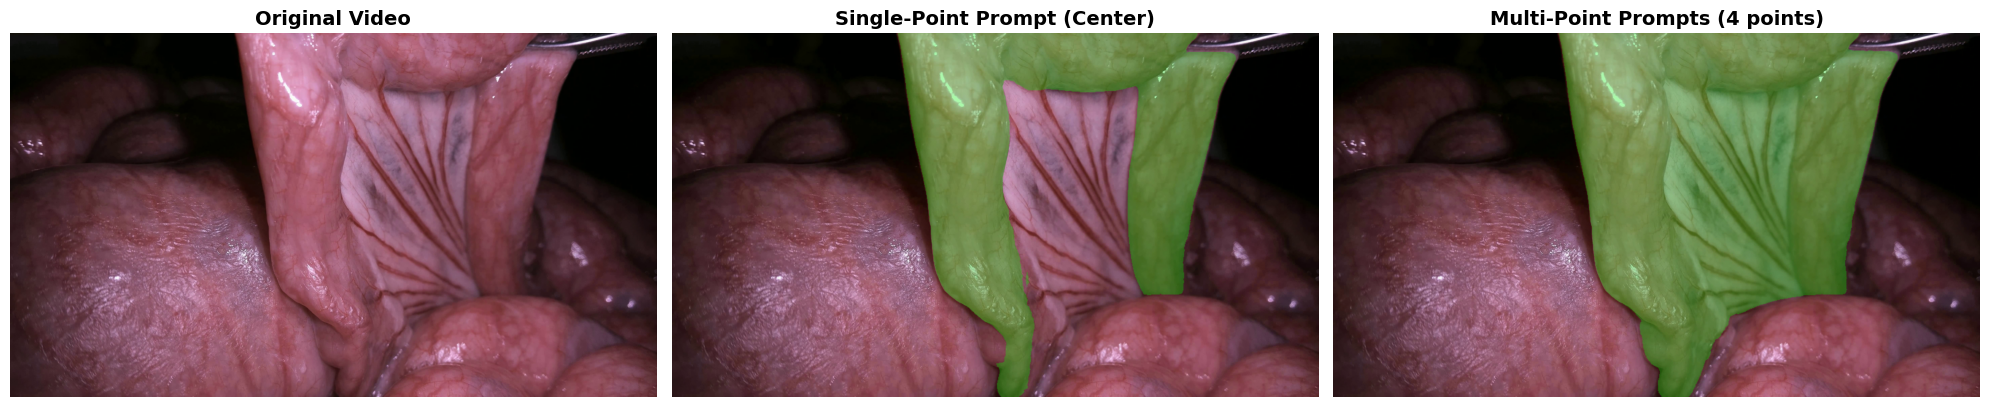

📊 Comparison Results:
   Frame: 75/150
   Single-point: Uses center of image
   Multi-point: Uses 4 strategic points on the tool

💡 Tips to improve further:
   1. Adjust prompt_points to target the surgical tool better
   2. Add negative prompts (background points) with label=0
   3. Try different frames if tools move significantly
   4. Use smaller resize_width for more detail (slower)


In [24]:
# Side-by-side comparison: Original vs Single-point vs Multi-point segmentation
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Get frame from middle of video
cap_orig = cv2.VideoCapture(str(test_video))
total_frames = int(cap_orig.get(cv2.CAP_PROP_FRAME_COUNT))
frame_idx = total_frames // 2

cap_orig.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret1, original = cap_orig.read()
cap_orig.release()

# Get same frame from single-point segmentation
single_point_video = OUTPUT_DIR / f"sam2_segmented_{Path(test_video).name}"
cap_single = cv2.VideoCapture(str(single_point_video))
cap_single.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret2, single_seg = cap_single.read()
cap_single.release()

# Get same frame from multi-point segmentation
cap_multi = cv2.VideoCapture(str(output_improved))
cap_multi.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret3, multi_seg = cap_multi.read()
cap_multi.release()

if ret1 and ret2 and ret3:
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Video", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(single_seg, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Single-Point Prompt (Center)", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(cv2.cvtColor(multi_seg, cv2.COLOR_BGR2RGB))
    axes[2].set_title(f"Multi-Point Prompts ({len(prompt_points)} points)", fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Comparison Results:")
    print(f"   Frame: {frame_idx}/{total_frames}")
    print(f"   Single-point: Uses center of image")
    print(f"   Multi-point: Uses {len(prompt_points)} strategic points on the tool")
    print("\n💡 Tips to improve further:")
    print("   1. Adjust prompt_points to target the surgical tool better")
    print("   2. Add negative prompts (background points) with label=0")
    print("   3. Try different frames if tools move significantly")
    print("   4. Use smaller resize_width for more detail (slower)")
else:
    print("❌ Could not load frames for comparison")

## Process All Videos with Multi-Point Prompts
Now process the first 10 videos using the improved multi-point prompting strategy

In [ ]:
# Process first 10 videos with multi-point prompting
N_VIDEOS = 10

# Multi-point strategy that worked well
prompt_strategy = [
    (0.5, 0.5),   # Center
    (0.4, 0.4),   # Upper left quadrant
    (0.6, 0.4),   # Upper right quadrant
    (0.5, 0.6),   # Lower center
]

print(f"\n🎬 Processing {N_VIDEOS} videos with multi-point SAM 2.1...\n")
print(f"📍 Using {len(prompt_strategy)}-point prompting strategy\n")

for i, video_path in enumerate(videos[:N_VIDEOS]):
    video_name = Path(video_path).name
    output_path = OUTPUT_DIR / f"multipoint_{video_name}"
    
    print(f"[{i+1}/{N_VIDEOS}] {video_name}")
    
    success = segment_video_improved(
        video_path, 
        output_path, 
        predictor, 
        resize_width=960,
        prompt_points=prompt_strategy
    )
    
    if success:
        print(f"  ✓ Completed\n")
    else:
        print(f"  ❌ Failed\n")

print("🎉 All videos processed!")
print(f"📂 Output location: {OUTPUT_DIR}")
print(f"\n💾 Total files: {len(list(OUTPUT_DIR.glob('multipoint_*.avi')))}")


🎬 Processing 10 videos with multi-point SAM 2.1...

📍 Using 4-point prompting strategy

[1/10] vid_01_3840x2160_5_sec_1_tool.avi
  Original: 3840x2160 @ 30.0 fps, 150 frames
  Extracting frames...
